In [15]:
import torch
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = torch.hub.load('ultralytics/yolov5', 'custom', path='../app/best.pt')
model.eval()

Using cache found in /home/denis/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-10-25 Python-3.10.7 torch-1.13.0+cpu CPU

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

In [32]:
res_path = '../data/exp/results.csv'
df = pd.read_csv(res_path, index_col='               epoch')
df.columns = [column.strip() for column in df.columns]
df

,train/box_loss,train/obj_loss,train/cls_loss,metrics/precision,metrics/recall,...,val/obj_loss,val/cls_loss,x/lr0,x/lr1,x/lr2
epoch,,,,,,,,,,,
0,0.071309,0.027747,0,0.39761,0.41212,...,0.021639,0,0.067051,0.000333,0.000333
1,0.059512,0.026519,0,0.43466,0.57693,...,0.022320,0,0.033985,0.000600,0.000600
2,0.055737,0.026002,0,0.51988,0.60635,...,0.021265,0,0.000853,0.000802,0.000802
3,0.051354,0.023641,0,0.77042,0.68138,...,0.017855,0,0.000703,0.000703,0.000703
4,0.047999,0.021807,0,0.86270,0.75726,...,0.015561,0,0.000703,0.000703,0.000703
5,0.044696,0.020695,0,0.80702,0.71673,...,0.016749,0,0.000604,0.000604,0.000604
6,0.042300,0.020031,0,0.89400,0.78294,...,0.014530,0,0.000505,0.000505,0.000505
7,0.040810,0.019415,0,0.90133,0.78781,...,0.013563,0,0.000406,0.000406,0.000406
8,0.038711,0.018667,0,0.91658,0.79496,...,0.013391,0,0.000307,0.000307,0.000307


#### Our model is taking statistics on losses and metrics every epoch. This statistics include box (regression) loss, obj loss on both test set and train set, and metrics such as precision, recall, M(ean)A(verage)P(recision) over I(ntersection)o(ver)U(nion) with threshold 0.5, average MAP over IoU with thresholds from 0.5 to 0.95

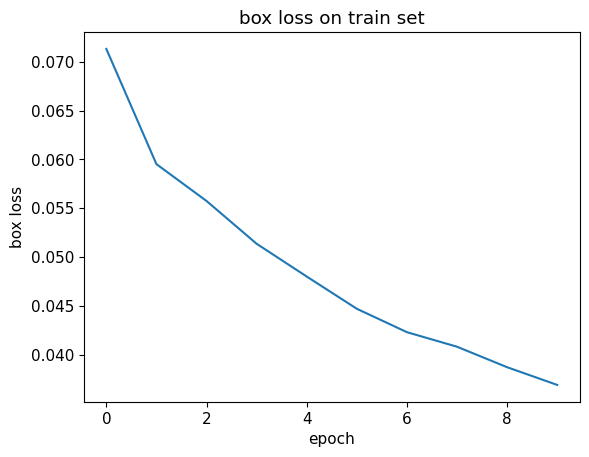

In [33]:
plt.xlabel("epoch")
plt.ylabel("box loss")
plt.title('box loss on train set')
plt.plot(df.index, df['train/box_loss'])

#### As we can see, with every epoch reduces loss quite drastically. At the end it peaks with value=0.036898 on train set and value=0.029857 at test set.

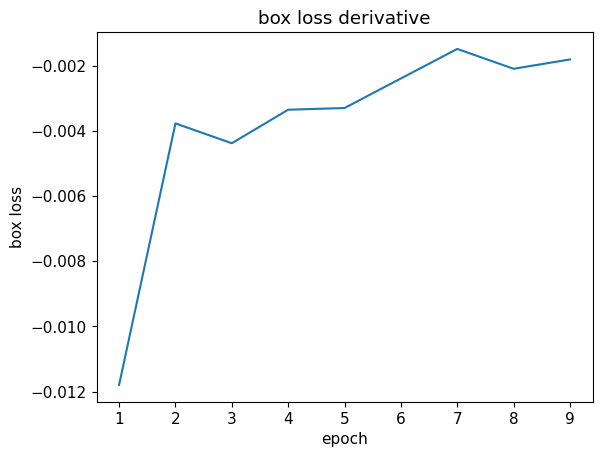

In [34]:
plt.xlabel("epoch")
plt.ylabel("box loss")
plt.title('box loss derivative')
plt.plot(df.index, df['train/box_loss'].diff())

#### Or more visually, it can be seen with taking difference of box loss between epochs. But after 10 epochs loss is small enough to stop the training.

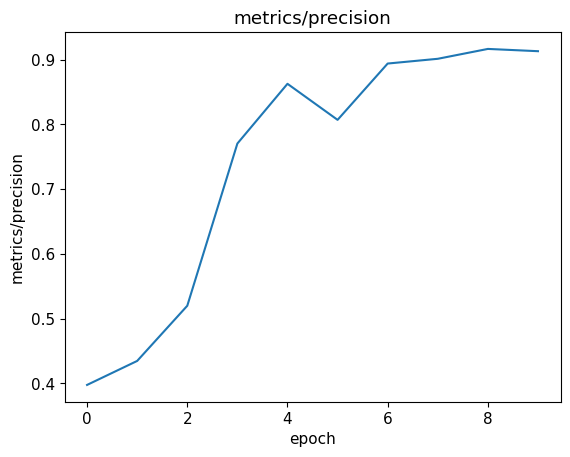

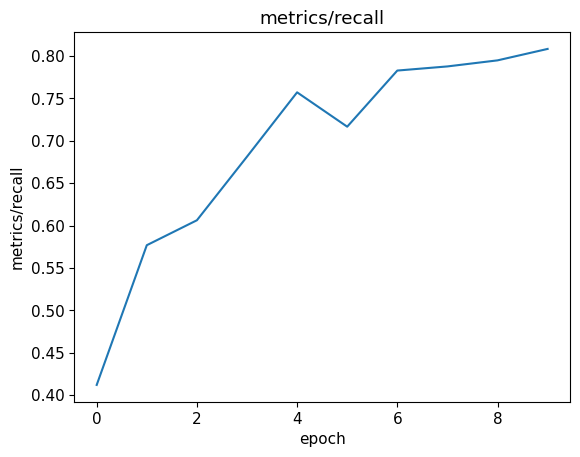

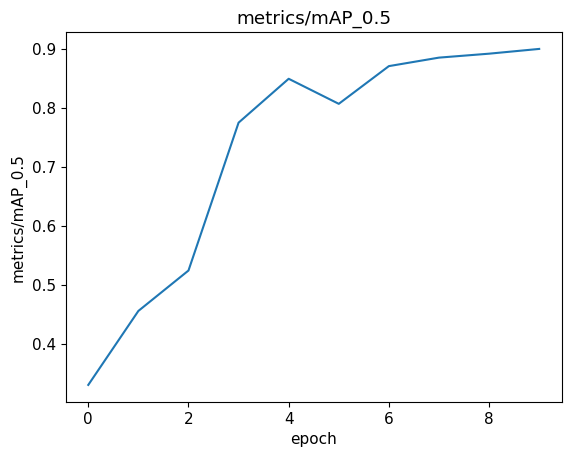

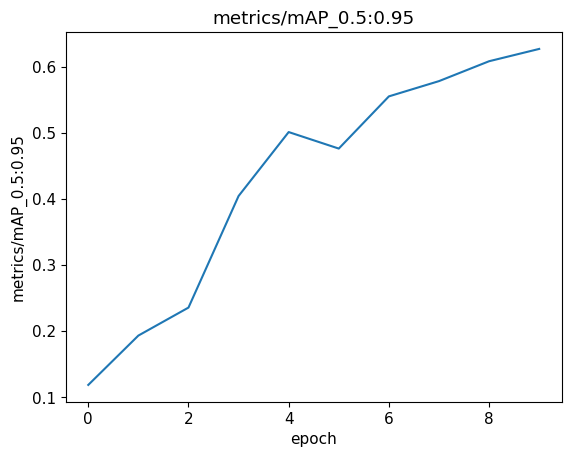

In [39]:
for ind, row in df[[column for column in df.columns if column.startswith('metrics')]].items():
    plt.figure()
    plt.xlabel("epoch")
    plt.ylabel(str(ind))
    plt.plot(df.index, row)
    plt.title(str(ind))

#### Recall at the end is 0.80846. While precision at the end is 0.91307. This statistic is tolerable for deployment.

In [50]:
res_path = '../data/processed_test.csv'
images = pd.read_csv(res_path, sep='\t', index_col=0)
images

,height,id,seq_id,location,width,...,file_name,seq_frame_num,seq_num_frames,sub_location,box
0,1024,8b31d3be-21bc-11ea-a13a-137349068a90,a91ebc18-0cd3-11eb-bed1-0242ac1c0002,20,1280,...,8b31d3be-21bc-11ea-a13a-137349068a90.jpg,0,10,NaN,"[[0, 0.55, 0.558, 0.438]]"
1,1024,8cf202be-21bc-11ea-a13a-137349068a90,a91ebc18-0cd3-11eb-bed1-0242ac1c0002,20,1280,...,8cf202be-21bc-11ea-a13a-137349068a90.jpg,1,10,NaN,"[[0, 0.557, 0.684, 0.431]]"
2,1024,8a87e62e-21bc-11ea-a13a-137349068a90,a91ebc18-0cd3-11eb-bed1-0242ac1c0002,20,1280,...,8a87e62e-21bc-11ea-a13a-137349068a90.jpg,2,10,NaN,"[[0, 0.418, 0.712, 0.581]]"
3,1024,8e6994f4-21bc-11ea-a13a-137349068a90,a91ebc18-0cd3-11eb-bed1-0242ac1c0002,20,1280,...,8e6994f4-21bc-11ea-a13a-137349068a90.jpg,3,10,NaN,"[[0, 0.402, 0.673, 0.584]]"
4,1024,948b29e2-21bc-11ea-a13a-137349068a90,a91ebc18-0cd3-11eb-bed1-0242ac1c0002,20,1280,...,948b29e2-21bc-11ea-a13a-137349068a90.jpg,4,10,NaN,"[[0, 0.547, 0.693, 0.439]]"
...,...,...,...,...,...,...,...,...,...,...,...
60024,1024,981aabf0-21bc-11ea-a13a-137349068a90,a91b0b90-0cd3-11eb-bed1-0242ac1c0002,5,1280,...,981aabf0-21bc-11ea-a13a-137349068a90.jpg,0,5,1.0,"[[0.023, 0.566, 0.396, 0.217]]"
60025,1024,971d8466-21bc-11ea-a13a-137349068a90,a91b0b90-0cd3-11eb-bed1-0242ac1c0002,5,1280,...,971d8466-21bc-11ea-a13a-137349068a90.jpg,1,5,1.0,"[[0.23, 0.576, 0.372, 0.184]]"
60026,1024,90f05d20-21bc-11ea-a13a-137349068a90,a91b0b90-0cd3-11eb-bed1-0242ac1c0002,5,1280,...,90f05d20-21bc-11ea-a13a-137349068a90.jpg,2,5,1.0,"[[0.398, 0.565, 0.345, 0.187]]"
60027,1024,903c3ebc-21bc-11ea-a13a-137349068a90,a91b0b90-0cd3-11eb-bed1-0242ac1c0002,5,1280,...,903c3ebc-21bc-11ea-a13a-137349068a90.jpg,3,5,1.0,"[[0.535, 0.557, 0.341, 0.192]]"


In [51]:
pd.options.mode.chained_assignment = None
def predict_bboxes(img: list[Image.Image]) -> list[pd.DataFrame]:
    def make_bbox(df):
        filtered_df = df[df['confidence'] > 0.3]
        bbox = filtered_df[['xmin', 'ymin', 'xmax', 'ymax']]
        return bbox

    data = model(img)
    bboxes = [make_bbox(im) for im in data.pandas().xyxy]
    return bboxes
def count_animals(old_bboxes: pd.DataFrame, new_bboxes: pd.DataFrame) -> int:
    def cond(x, y) -> bool:
        threshold = 1000
        x = torch.from_numpy(x.to_numpy())
        y = torch.from_numpy(y.to_numpy())
        s = torch.sum(torch.abs(x - y)).item()
        return s < threshold

    bbox = new_bboxes.copy()
    bbox['prev'] = False
    for i in range(len(old_bboxes)):
        for j in range(len(new_bboxes)):
            if bbox.iloc[j]['prev']:
                continue
            if cond(old_bboxes.iloc[i], new_bboxes.iloc[j]):
                bbox['prev'][j] = True
    return bbox[bbox['prev'] == True].size.item()
def predict_sequence(bboxes: list[pd.DataFrame]):
    count = bboxes[0].shape[0]
    for i in range(len(bboxes) - 1):
        count += count_animals(bboxes[i], bboxes[i + 1])
    return count
def predict(files: list[str]):
    images = [Image.open(file) for file in files]
    sequence = predict_bboxes(images)
    return predict_sequence(sequence)

In [52]:
seq_id = 'a91ebc18-0cd3-11eb-bed1-0242ac1c0002'
seq = images[images['seq_id'] == seq_id]
image_dir = '../../../ML/project/data/test/'
files = [image_dir + file for file in seq.sort_values(by='seq_frame_num')['file_name'].tolist()]
predict(files)

46